## Segmentation using CrossViT

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cv2

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import torchvision.transforms as transforms
from torchvision import models
import numpy as np
from tqdm import tqdm

import os
from PIL import Image
import torch
from torch.utils.data import Dataset

In [2]:
sample_image =  np.load("/raid/biplab/phduser2/ddp/CrossViT/citiscapes/train/image/1105.npy")
sample_label =  np.load("/raid/biplab/phduser2/ddp/CrossViT/citiscapes/train/label/1105.npy")

In [3]:
print(np.unique(sample_label))
print(sample_image.shape)

[-1.  0.  1.  2.  3.  4.  5.  6.]
(128, 256, 3)


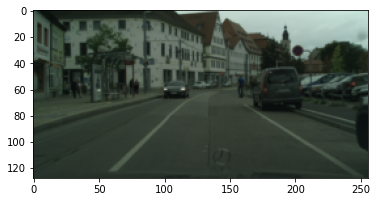

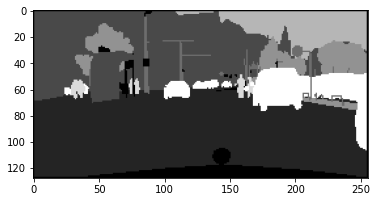

In [4]:

# sample_image = cv2.resize(sample_image,(240, 240))
# sample_label = cv2.resize(sample_label,(240, 240))

plt.imshow(sample_image, cmap='gray')  # 'gray' colormap for grayscale images
plt.show()
plt.imshow(sample_label, cmap='gray')  # 'gray' colormap for grayscale images
# plt.axis('off')  # Turn off axis labels
plt.show()

In [5]:
from scipy.ndimage import zoom

In [6]:
import cv2
def z_score_normalization(image):
    mean = np.mean(image)
    std = np.std(image)
    normalized_image = (image - mean) / std
    return normalized_image

In [7]:
from sklearn.preprocessing import StandardScaler

class CustomDataset(Dataset):
    def __init__(self, image_folder, label_folder, transform=None):
        # Load and preprocess your dataset here
        self.transform = transform

        image_dir = image_folder
        label_dir = label_folder
        
        self.image_files = [os.path.join(image_dir, img) for img in os.listdir(image_dir)]
        self.label_files = [os.path.join(label_dir, lbl) for lbl in os.listdir(label_dir)]
        

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, i):
        img_path = self.image_files[i]
        label_path = self.label_files[i]
        
        image = np.load(img_path)
        # image = (image * 255).astype(np.uint8)
        # print(image.dtype)
        label = np.load(label_path)
        # image = cv2.resize(image,(240, 240))
        # label = cv2.resize(label, (240, 240), interpolation=cv2.INTER_NEAREST)

        # resized_tensor = zoom(label, zoom=(240/128,240/256), order=0)
        
        # label = np.clip(label, a_min=-1, a_max=6)
        
        # if self.transform:
        #     image = self.transform(image)
            # label = self.transform(label)
        # z_score_scaler = StandardScaler()
        # image = z_score_scaler.fit_transform(image.reshape(-1, 1))
        image = z_score_normalization(image)

        image = torch.from_numpy(image)
        label = torch.from_numpy(label)
        label = torch.tensor(label).unsqueeze(0)
        
        # image = image.permute(1, 2, 0)
        label = label.permute(1, 2, 0)
        
        one_hot_labels = np.zeros((label.shape[0], label.shape[1], 8), dtype=np.uint8)
        
        class_index = [-1,0,1,2,3,4,5,6]
        for i in range(8):
            a = (label[:,:,0] == class_index[i])  
            one_hot_labels[:, :, i] = a

        return image, one_hot_labels
        # Return a tuple of (image, label) here

In [9]:
## transforms.ToTensor() converts to transpose??

In [8]:
batch_size = 32

transform = transforms.Compose([
    transforms.ToTensor(),
    # transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

train_dataset = CustomDataset("/raid/biplab/phduser2/ddp/CrossViT/citiscapes/train/image", "/raid/biplab/phduser2/ddp/CrossViT/citiscapes/train/label", transform=transform)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)


val_dataset = CustomDataset("/raid/biplab/phduser2/ddp/CrossViT/citiscapes/val/image", "/raid/biplab/phduser2/ddp/CrossViT/citiscapes/val/label", transform=transform)
val_loader = DataLoader(val_dataset, batch_size=batch_size)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


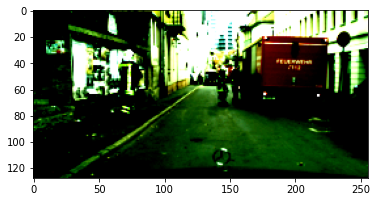

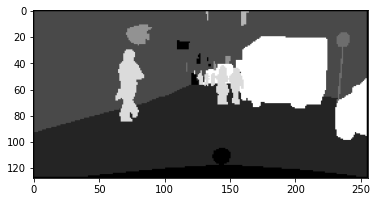

In [11]:
n = 7
plt.imshow(images[n], cmap='gray')  # 'gray' colormap for grayscale images
plt.show()
plt.imshow(labels[n], cmap='gray')  # 'gray' colormap for grayscale images
# plt.axis('off')  # Turn off axis labels
plt.show()

## Defining the Model

In [12]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset
import torchvision
import numpy as np

In [15]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import math
import torch.nn.functional as F

# Define constants
# image_size = 240
# patch_size = 20
# num_patches = (image_size // patch_size) ** 2
embedding_dim = 256
# num_heads = 4
# num_classes = 1000
# dropout_rate = 0.1

In [17]:
class patch_embedding(nn.Module):
    def __init__(self, patch_size, embedding_dim):
        super(patch_embedding, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, kernel_size=patch_size, stride=patch_size)
        self.bn1 = nn.BatchNorm2d(64)
        self.conv2 = nn.Conv2d(64, 256, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(256)
        self.conv3 = nn.Conv2d(256, embedding_dim, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(embedding_dim)
        # self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        # self.fc1 = nn.Linear(64 * (240 // (2*patch_size)) * (240// (2*patch_size)), 256)
        # self.fc2 = nn.Linear(256, 256)  # Modify the output size of this fully connected layer

    def forward(self, x):
        x = torch.relu(self.bn1(self.conv1(x)))
        x = torch.relu(self.bn2(self.conv2(x)))
        x = torch.relu(self.bn3(self.conv3(x)))
        # x = x.view(x.size(0), -1)
        # x = torch.relu(self.fc1(x))
        # x = self.fc2(x)  # Output size is now (16, 144, 256)
        return x


In [18]:

# Create a positional encoding module
class positional_encoding(nn.Module):
    def __init__(self, d_model, max_seq_len=10000):
        super(positional_encoding, self).__init__()
        pe = torch.zeros(max_seq_len, d_model)
        position = torch.arange(0, max_seq_len, dtype=torch.float64).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2, dtype=torch.float64) * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)
        self.register_buffer('pe', pe)

    def forward(self, x):
        return x + self.pe[:, :x.size(1)]
    

In [19]:

    
class token(nn.Module):
    def __init__(self,patch_size, embedding_dim):
        super(token, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, kernel_size=patch_size,stride=patch_size)
        self.bn1 = nn.BatchNorm2d(64)
        self.conv2 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(128)
        self.conv3 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(256)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(256 * (128 // (4*patch_size)) * (256// (4*patch_size)), 256)
        self.fc2 = nn.Linear(256, embedding_dim)  # Modify the output size of this fully connected layer

    def forward(self, x):
        x = self.pool(torch.relu(self.bn1(self.conv1(x))))
        x = self.pool(torch.relu(self.bn2(self.conv2(x))))
        x = torch.relu(self.bn3(self.conv3(x)))
        x = x.reshape(x.size(0), -1)
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)  # Output size is now (16, 144, 256)
        x = x.unsqueeze(1)
        return x


In [21]:

class upscale_layers(nn.Module):
    def __init__(self, scale_factor, output_dim, input_dimension):
        super(upscale_layers, self).__init__()
        # self.conv1 = nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1)
        # self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.upconv = nn.ConvTranspose2d(input_dimension, output_dim, kernel_size=scale_factor, stride=scale_factor)

    def forward(self, x):
        # x = self.conv1(x)
        # x = self.pool(x)
        x = self.upconv(x)
        return x

In [22]:

    
# class token(nn.Module):
#     def __init__(self,patch_size, embedding_dim):
#         super(token, self).__init__()
#         self.conv1 = nn.Conv2d(3, 64, kernel_size=patch_size,stride=patch_size)
#         self.conv2 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
#         self.conv3 = nn.Conv2d(128, 128, kernel_size=3, padding=1)
#         self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
#         self.fc1 = nn.Linear(128 * (128 // (4*patch_size)) * (256// (4*patch_size)), 256)
#         self.fc2 = nn.Linear(256, embedding_dim)  # Modify the output size of this fully connected layer

#     def forward(self, x):
#         x = self.pool(torch.relu(self.conv1(x)))
#         x = self.pool(torch.relu(self.conv2(x)))
#         x = torch.relu(self.conv3(x))
#         x = x.reshape(x.size(0), -1)
#         x = torch.relu(self.fc1(x))
#         x = self.fc2(x)  # Output size is now (16, 144, 256)
#         x = x.unsqueeze(1)
#         return x
    
class last_cnn(nn.Module):
    def __init__(self, output_dim, input_dimension):
        super(last_cnn, self).__init__()
        self.conv1 = nn.Conv2d(input_dimension, 128, kernel_size=3,padding=1)
        self.bn1 = nn.BatchNorm2d(128)
        self.conv2 = nn.Conv2d(128, 128, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(128)
        self.conv3 = nn.Conv2d(128, output_dim, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(output_dim)
        # self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

    def forward(self, x):
        x = torch.relu(self.bn1(self.conv1(x)))
        x = torch.relu(self.bn2(self.conv2(x)))
        x = torch.relu(self.bn3(self.conv3(x)))
        return x

In [23]:
class SelfAttention(nn.Module):
    def __init__(self, embed_size, heads):
        super(SelfAttention, self).__init__()
        self.embed_size = embed_size
        self.heads = heads
        self.head_dim = embed_size // heads

        assert (
            self.head_dim * heads == embed_size
        ), "Embedding size needs to be divisible by heads"

        # Linear transformation for queries, keys, and values
        self.values = nn.Linear(self.head_dim, self.head_dim, bias=False)
        self.keys = nn.Linear(self.head_dim, self.head_dim, bias=False)
        self.queries = nn.Linear(self.head_dim, self.head_dim, bias=False)
        self.fc_out = nn.Linear(heads * self.head_dim, embed_size)

    def forward(self, values, keys, query, mask):
        N = query.shape[0]
        value_len, key_len, query_len = values.shape[1], keys.shape[1], query.shape[1]

        # Split the embedding into self.heads different pieces
        values = values.reshape(N, value_len, self.heads, self.head_dim)
        keys = keys.reshape(N, key_len, self.heads, self.head_dim)
        queries = query.reshape(N, query_len, self.heads, self.head_dim)

        values = self.values(values)
        keys = self.keys(keys)
        queries = self.queries(queries)

        # Scaled dot-product attention
        energy = torch.einsum("nqhd,nkhd->nhqk", [queries, keys])  # Batch-wise matrix multiplication
        if mask is not None:
            energy = energy.masked_fill(mask == 0, float("-1e20"))

        attention = torch.nn.functional.softmax(energy / (self.embed_size ** (1 / 2)), dim=3)

        out = torch.einsum("nhql,nlhd->nqhd", [attention, values]).reshape(
            N, query_len, self.heads * self.head_dim
        )

        out = self.fc_out(out)

        return out

In [423]:



# Define the Vision Transformer model
class transformer_block(nn.Module):
    def __init__(self, image_size, patch_size1, patch_size2, embedding_dim):
        super(transformer_block, self).__init__()
        self.patch_size1 = patch_size1
        self.patch_size2 = patch_size2
        
        self.patch_embedding1 = patch_embedding(patch_size1, embedding_dim) # two different patch embeddings, because it would if we have two CNN models based on patch size for feature extraction
        self.patch_embedding2 = patch_embedding(patch_size2, embedding_dim)

        self.positional_encoding = positional_encoding(embedding_dim)

        self.token1=token(patch_size1, embedding_dim) # this is what will be shared while applying cross attention
        self.token2=token(patch_size2, embedding_dim)

        self.SelfAttention1  = SelfAttention(embedding_dim,heads=4)
        self.SelfAttention2  = SelfAttention(embedding_dim,heads=4)
        
        self.CrossAttention1 = SelfAttention(embedding_dim,heads=4)
        self.CrossAttention2 = SelfAttention(embedding_dim,heads=4)
        
        self.upscale_layers_x1_1 = upscale_layers(2,128, embedding_dim)
        self.upscale_layers_x1_2 = upscale_layers(2,128, 128)
        self.upscale_layers_x1_3 = upscale_layers(2,128, 128)
        self.upscale_layers_x1_4 = upscale_layers(2,128, 128)

        self.upscale_layers_x2_1 = upscale_layers(2,128, embedding_dim)
        self.upscale_layers_x2_2 = upscale_layers(2,128, 128)
        self.upscale_layers_x2_3 = upscale_layers(2,128, 128)

        self.last_cnn = last_cnn(8,128)

        # self.patch_extractor = PatchExtractor()
        # self.embedding1 = nn.Linear(num_patches, embedding_dim)
        # self.transformer = nn.Transformer(embedding_dim, num_heads=4)
        # self.classifier = nn.Linear(embedding_dim, num_classes)
        # self.dropout = nn.Dropout(dropout_rate)

    def forward(self, x):
        # B is batch_size
        # E is embedding _size
        x1 = self.patch_embedding1(x) 
        x2 = self.patch_embedding2(x) # output is [B, E, a, b], (a,b) = (128,256)/patch-size
        
        B, C, _, _ = x1.shape
        x1 = x1.view(B, C, -1).permute(0,2,1)
        x2 = x2.view(B, C, -1).permute(0,2,1) 
        
        x1 = self.positional_encoding(x1)
        x2 = self.positional_encoding(x2) # output is [B, a*b, E]

        x1_cls = self.token1(x)
        x2_cls = self.token2(x) # output is [B, 1, E]

        x1 = torch.cat((x1_cls,x1),dim=1) # x1 sized increased here to [B, a*b+1, E]
        x2 = torch.cat((x2_cls,x2),dim=1) # x2 sized increased here to [B, a*b+1, E]
        
        x1 = self.SelfAttention1(x1,x1,x1,None)
        x2 = self.SelfAttention2(x2,x2,x2,None)
    
        x1_cls, x1 = x1[:,:1,:],x1[:,1:129,:]
        x2_cls, x2 = x2[:,:1,:],x2[:,1:513,:]

        
        x1 = torch.cat((x1_cls,x1),dim=1) # x1 sized increased here to [B, a*b+1, E]
        x2 = torch.cat((x2_cls,x2),dim=1) # x2 sized increased here to [B, a*b+1, E]        

        x1 = self.CrossAttention1(x1,x1,x1,None)
        x2 = self.CrossAttention2(x2,x2,x2,None)
        
        x2_cls, x1 = x1[:,:1,:],x1[:,1:129,:]
        x1_cls, x2 = x2[:,:1,:],x2[:,1:513,:]

        x1 = x1.unsqueeze(1).view(x1.shape[0], 8, 16, embedding_dim) ## change this according to number of patches
        x2 = x2.unsqueeze(1).view(x2.shape[0], 16, 32, embedding_dim)

        # DECODER STARTED
        x1 = x1.permute(0,3,1,2)
        x2 = x2.permute(0,3,1,2)

        x1 = self.upscale_layers_x1_1(x1)
        x1 = self.upscale_layers_x1_2(x1)
        x1 = self.upscale_layers_x1_3(x1)
        x1 = self.upscale_layers_x1_4(x1)
        
        x2 = self.upscale_layers_x2_1(x2)
        x2 = self.upscale_layers_x2_2(x2)
        x2 = self.upscale_layers_x2_3(x2)

        x = x1+x2

        x = self.last_cnn(x)
        x = F.softmax(x, dim=1)
        # print(x.size())
        # _, max_indices = torch.max(x, dim=-1)
        # one_hot_encoding = torch.zeros_like(x)
        # one_hot_encoding.scatter_(1, max_indices.view(-1, 1), 1)
        return x.permute(0,2,3,1)


In [446]:
model = transformer_block(240,16,8, embedding_dim)
# model.load_state_dict(torch.load('seg_map_22_epoch.pth'))

In [447]:
def get_pix_acc(truth, pred):
  
  # mask1 = F.one_hot(truth, num_classes=8).float() 
  # mask2 = F.one_hot(pred, num_classes=8).float() 

  # intersection = np.logical_and(mask1.detach().numpy(), mask2.detach().numpy())

  truth = torch.argmax(truth, dim=-1, keepdim=True)
  pred = torch.argmax(pred, dim=-1, keepdim=True)

  # print(truth.shape)
  # print(pred.shape)
  
  correctl_predicted = (truth==pred)
  
  pix_acc = correctl_predicted.sum() / (truth.shape[0]*truth.shape[1]*truth.shape[2])

  return pix_acc

In [448]:
def get_miou(truth, pred):
    
    # mask1 = F.one_hot(truth, num_classes=8).float() 
    # mask2 = F.one_hot(pred, num_classes=8).float() 

    intersection = np.logical_and(truth.detach().numpy(), pred.detach().numpy()).sum()
    
    union = np.logical_or(truth.detach().numpy(), pred.detach().numpy()).sum()
    
    miou = intersection / union if union != 0 else 1.0  # Avoiding division by zero
    return miou


In [449]:
a = np.random.randint(0, 3, size=(32, 128, 256))
b = np.random.randint(0, 3, size=(32, 128, 256))

a = F.one_hot(torch.tensor(a), num_classes=8)
b = F.one_hot(torch.tensor(b), num_classes=8)

# print(a[0,:2,:3,:2])
# print(b[0,:2,:3,:2])

print(get_pix_acc(torch.tensor(a[:1,:2,:3,:3]),torch.tensor(b[:1,:2,:3,:3])))
# print(get_miou(torch.tensor(a[:1,:2,:3,:2]),torch.tensor(b[:1,:2,:3,:2])))

tensor(0.1667)


<ipython-input-449-d038fec3bafd>:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print(get_pix_acc(torch.tensor(a[:1,:2,:3,:3]),torch.tensor(b[:1,:2,:3,:3])))


In [450]:

desired_sample_index = 1
i=0
for batch_idx, (images, labels) in enumerate(val_loader):
    if batch_idx == desired_sample_index:
        # Access a specific data point within the batch
        specific_image = images[1]
        specific_label = labels[1]
        break

<ipython-input-7-f531a0344c7c>:42: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label).unsqueeze(0)


In [451]:

# Use torch.argmax to convert to index-based representation
a = model(images.float().permute(0,3,1,2))

index_image = torch.argmax(a, dim=-1, keepdim=True)
index_label = torch.argmax(labels,dim=-1,keepdim=True)

In [454]:
index_image.shape

torch.Size([32, 128, 256, 1])

In [ ]:
# index_image
n=0
plt.imshow(images[n,:,:,0])  # 'gray' colormap for grayscale images
plt.axis('off')  # Turn off axis labels
plt.show()
plt.imshow(index_image[n,:,:,0], cmap='gray')  # 'gray' colormap for grayscale images
plt.axis('off')  # Turn off axis labels
plt.show()

plt.imshow(index_label[n], cmap='gray')  # 'gray' colormap for grayscale images
plt.axis('off')  # Turn off axis labels
plt.show()

In [281]:
iou=0
pix_acc=0
for batch_idx, (images, labels) in enumerate(val_loader):
    pred = model(images.float().permute(0,3,1,2))
    # pred = torch.argmax(pred, dim=-1, keepdim=True)
    # labels = torch.argmax(labels, dim=-1, keepdim=True)
    # print(pred.shape)
    # print(labels.shape)
    iou+=get_miou(pred[:,:,:,0],labels[:,:,:,0])
    pix_acc+=get_pix_acc(pred[:,:,:,0],labels[:,:,:,0])


<ipython-input-7-f531a0344c7c>:42: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label).unsqueeze(0)


In [430]:
print(iou/len(val_loader))
print(pix_acc/len(val_loader))

0.12805949449539183
0.12805949449539183


In [232]:
n=9
iou = get_miou(index_image[:,:,:,0],index_label[:,:,:,0])
print(iou)

0.7854440846670427


In [116]:
# def dice_loss(pred, target, epsilon=1e-5):
#     intersection = torch.sum(pred * target)
#     union = torch.sum(pred) + torch.sum(target)
#     loss = 1 - (2.0 * intersection + epsilon) / (union + epsilon)
#     return loss



In [456]:
def dice_loss(y_true, y_pred, epsilon=1e-5):
    intersection = torch.sum(y_true * y_pred)
    union = torch.sum(y_true) + torch.sum(y_pred)

    dice_coefficient = (2. * intersection + epsilon) / (union + epsilon)
    dice_loss = 1. - dice_coefficient

    return dice_loss

In [457]:

# criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
num_epochs = 40  # Set the number of epochs


In [458]:
def convert_to_one_hot_max(input_tensor):
    # Get the index with the maximum value along the last dimension
    max_index = torch.argmax(input_tensor, dim=-1)

    # Create a one-hot encoded tensor
    one_hot_tensor = torch.zeros_like(input_tensor)
    one_hot_tensor.scatter_(-1, max_index.unsqueeze(-1), 1)

    return one_hot_tensor

In [459]:
input_tensor = torch.randn(32, 128, 256, 8)
# Ensure that the input tensor's values sum to 1 along the last dimension
input_tensor = torch.nn.functional.softmax(input_tensor, dim=-1)
print(convert_to_one_hot_max(input_tensor[:1,:1,:1,:]))
print(input_tensor[:1,:1,:1,:])

tensor([[[[0., 1., 0., 0., 0., 0., 0., 0.]]]])
tensor([[[[0.0354, 0.2133, 0.2104, 0.1234, 0.0541, 0.0981, 0.2065, 0.0588]]]])


In [460]:
val_loss=[]
val_miou=[]
val_pix_acc=[]

In [ ]:
for epoch in range(num_epochs):
    model.train()
    total_loss = 0.0

    # for batch_idx, (images, labels) in enumerate(train_loader):
    for batch_idx, (images, labels) in enumerate(train_loader):
        # Replace with your data loader
        # Forward pass
        print("epoch, batch_idx: ", epoch,batch_idx)
        predictions = model(images.float().permute(0,3,1,2))

        # Calculate the Dice Loss
        loss = dice_loss(predictions, labels.float())

        # Backpropagation and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        print('loss: ',loss)

    # Calculate and print the average loss for this epoch
    average_loss = total_loss / len(train_loader)
    print(f"Epoch [{epoch+1}/{num_epochs}] - Dice Loss: {average_loss:.4f}")

    v_loss=0
    v_miou=0
    v_pix_acc=0
    for batch_idx, (images, labels) in enumerate(val_loader):
        # print(batch_idx)
        pred = model(images.float().permute(0,3,1,2))
        v_loss += dice_loss(pred, labels.float()).item()
        v_miou += get_miou(convert_to_one_hot_max(pred), labels)
        v_pix_acc += get_pix_acc(convert_to_one_hot_max(pred), labels)
    
    val_loss.append(v_loss)
    val_miou.append(v_miou)
    val_pix_acc.append(v_pix_acc)
    np.savetxt('val_loss.txt', val_loss)
    np.savetxt('val_pix_acc.txt', val_pix_acc)
    np.savetxt('val_miou.txt', val_miou)
    
    model_path = 'seg_map_new.pth'
    torch.save(model.state_dict(), model_path)

In [477]:

np.savetxt('val_loss.txt', np.array(val_loss)*32/500)
np.savetxt('val_pix_acc.txt', np.array(val_pix_acc)*32/500)
np.savetxt('val_miou.txt', np.array(val_miou)*32/500)

In [464]:
len(val_loader)

16

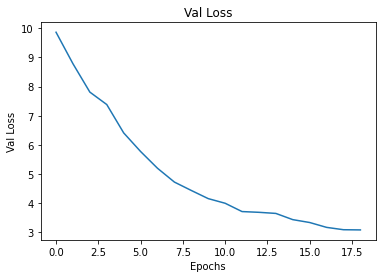

In [471]:
plt.plot(range(len(val_loss)), val_loss)

# Adding labels and title
plt.xlabel('Epochs')
plt.ylabel('Val Loss')
plt.title('Val Loss')

# Display the plot
plt.show()

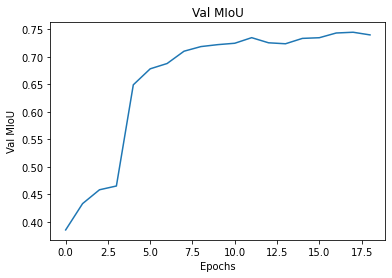

In [470]:
plt.plot(range(len(val_miou)), np.array(val_miou)*32/500)

# Adding labels and title
plt.xlabel('Epochs')
plt.ylabel('Val MIoU')
plt.title('Val MIoU')

# Display the plot
plt.show()

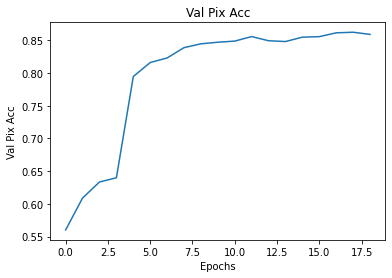

In [469]:
plt.plot(range(len(val_pix_acc)), np.array(val_pix_acc)*32/500)

# Adding labels and title
plt.xlabel('Epochs')
plt.ylabel('Val Pix Acc')
plt.title('Val Pix Acc')

# Display the plot
plt.show()